# This is Reinforce (Monte Carlo Policy Gradient Algorithm) 

In [95]:
# conda install matlotlib

In [100]:
import matplotlib.pyplot as plt
import numpy as np
import random
import os
import time
#environment
import gym
#pytorch
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
use_cuda = torch.cuda.is_available()
FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if use_cuda else torch.LongTensor
ByteTensor = torch.cuda.ByteTensor if use_cuda else torch.ByteTensor
Tensor = FloatTensor

In [101]:
def reinforce_init(size, fanin=None):
    fanin = fanin or size[0]
    v = 1. / np.sqrt(fanin)
    return torch.Tensor(size).normal_(0.0, v)

class neural_net(nn.Module):
    def __init__(self, discrete, input_size, output_size):
        super(neural_net, self).__init__()
        self.discrete = discrete
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 128)
        if discrete:
            self.fc3 = nn.Linear(128, output_size)
        else:
            self.fc3 = nn.Linear(128, 2*output_size)
            
        self.weights_i()
        self.optimizer = torch.optim.Adam(self.parameters(), lr = learning_rate)
    
    def weights_i(self, init_w=10e-3):
        self.fc1.weight.data = reinforce_init(self.fc1.weight.data.size())
        self.fc2.weight.data = reinforce_init(self.fc2.weight.data.size())
        self.fc3.weight.data.normal_(0, 3e-3)            
        
    def forward(self, x):
        out = F.relu(self.fc1(x))
        out = F.relu(self.fc2(out))
        if discrete:
            out = F.softmax(self.fc3(out), dim=0)
        return out

In [102]:
def actions(logit, env):
    # logit is the output of the softmax/linear layer
    dist = torch.distributions.Categorical(logit)
    action = dist.sample()
    log_prob = dist.log_prob(action)
    return action.cpu().data.numpy(), log_prob
def make_tensor(x, volatile=False, requires_grad=True, dtype=Tensor):
    x = torch.from_numpy(x).float()
    x = Variable(x, requires_grad=requires_grad).type(dtype=dtype)
    return x
def update_fun(paths, net):
    
    policy_loss=torch.empty(len(paths), requires_grad=False)
    
    for i,path in enumerate(paths):
        reward = make_tensor(path['reward'])
        
        revIdx = np.array([idx for idx in range(reward.shape[0]-1,-1,-1)])
        
        revIdx = make_tensor(revIdx, dtype=LongTensor)
        inverted_reward = reward.index_select(0, revIdx)
        inverted_reward = torch.cumsum(inverted_reward, dim=0)
        rews_cum = inverted_reward.index_select(0, revIdx)
        rews_cum = (rews_cum - rews_cum.mean()) / (rews_cum.std() + 1e-5) # create baseline
        log_prob = path['log_probs']
        policy_loss[i] = torch.matmul(-rews_cum,log_prob).sum()
    # calculate policy loss and average over paths
    policy_loss = policy_loss.mean()
    
    # take optimizer step
    net.optimizer.zero_grad()
    policy_loss.backward()
    net.optimizer.step()

In [103]:
min_timesteps_per_batch = 2000  # sets the batch size for updating network
logging_interval = 100
animate_interval = logging_interval * 1

env_name='Acrobot-v1'

env = gym.make(env_name)
visualize = False
animate=False

learning_rate = 0.001
max_path_length=1000
env._max_episode_steps = max_path_length
env._max_episode_steps = min_timesteps_per_batch
discrete = isinstance(env.action_space, gym.spaces.Discrete)
obs_dim = env.observation_space.shape[0]
if discrete:
    act_dim = env.action_space.n 
max_path_length = max_path_length or env.spec.max_episode_steps
net = mlp(discrete, obs_dim, act_dim)
net.cpu()
f1_in = net.fc1.weight.cpu().data.numpy()
f2_in = net.fc2.weight.cpu().data.numpy()
f3_in = net.fc3.weight.cpu().data.numpy()

VISUALIZE = False
n_iter = 1000 
avg_reward = 0
avg_rewards = []
step_list_reinforce = []
total_steps = 0
episodes = 0
reached = animate_interval

for itr in range(n_iter):
    paths = []
    steps = 0
    
    while True: # loop to get enough timesteps in this batch --> if episode ends this loop will restart till steps reaches limit
        state = env.reset()
        observation, acs, rews, log_probs = [], [], [], []
        while True: # loop for episode inside batch
            logit = net(make_tensor(state))
            
            action, log_prob = actions(logit, env)
            
            next_state, reward, done, _ = env.step(action)
            
            rews.append(reward)
            log_probs.append(log_prob)            
            observation.append(state)
            acs.append(action)

            
            steps += 1
            
            if done:
                episodes = episodes + 1
                break
                
            state = next_state
                
        path = {"observation" : observation, "reward" : np.array(rews), "action" : (acs),"log_probs" : torch.stack(log_probs)}
        
        paths.append(path)
        
        if steps > min_timesteps_per_batch:
            break 
        
    #print(paths)
    update_fun(paths, net)
    if itr == 0:
        avg_reward = path['reward'].sum()
    else:
        avg_reward = avg_reward * 0.95 + 0.05 * path['reward'].sum()
    
    if avg_reward > -99:
        state = env.reset()
        if reached>0:
            break
        reached += 1
    
    total_steps += steps
    avg_rewards.append(avg_reward)
    step_list_reinforce.append(total_steps)
    if itr % 1 == 0:
        print('Average reward: {}'.format(avg_reward))

env.close()
# plt.plt(avg_rewards)

Average reward: -652.0
Average reward: -665.25
Average reward: -731.9875
Average reward: -722.888125
Average reward: -772.69371875
Average reward: -834.0590328124999
Average reward: -854.7060811718749
Average reward: -851.3207771132811
Average reward: -867.8047382576169
Average reward: -924.414501344736
Average reward: -929.0437762774992
Average reward: -982.5915874636243
Average reward: -1003.812008090443
Average reward: -1001.6714076859207
Average reward: -984.7878373016247
Average reward: -954.7484454365434
Average reward: -936.4610231647163
Average reward: -919.1379720064804
Average reward: -911.1810734061563
Average reward: -907.7220197358484
Average reward: -897.085918749056
Average reward: -894.0816228116031
Average reward: -875.0775416710229
Average reward: -875.6736645874718
Average reward: -868.0899813580982
Average reward: -861.4854822901932
Average reward: -845.7612081756836
Average reward: -828.8731477668994
Average reward: -808.5794903785543
Average reward: -786.400515859

AttributeError: module 'matplotlib.pyplot' has no attribute 'plt'

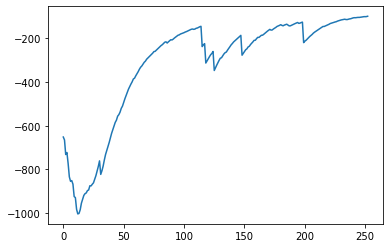

In [104]:
import matplotlib.pyplot as plt
plt.plot(avg_rewards)

#  This is Actor Critic (A2C) with Advantage Function Algorithm

In [105]:
from torch.distributions import Categorical

class neural_net1(nn.Module):

    def __init__(self, input_dim, output_dim):
        super(neural_net1, self).__init__()
        self.policy1 = nn.Linear(input_dim, 256) 
        self.policy2 = nn.Linear(256, output_dim)

        self.value1 = nn.Linear(input_dim, 256)
        self.value2 = nn.Linear(256, 1)
        
    def forward(self, state):
        logits = F.relu(self.policy1(state))
        logits = self.policy2(logits)

        value = F.relu(self.value1(state))
        value = self.value2(value)

        return logits, value

class Agent1():

    def __init__(self, env, gamma, lr):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        self.env = env
        self.obs_dim = env.observation_space.shape[0]
        self.action_dim = env.action_space.n
        
        self.gamma = gamma
        self.lr = lr
        
        self.model = neural_net1(self.obs_dim, self.action_dim)
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.lr)
    
    def get_action(self, state):
        state = torch.FloatTensor(state).to(self.device)
        logits, _ = self.model.forward(state)
        dist = F.softmax(logits, dim=0)
#         dist =   torch.nn.utils.clip_grad_norm_(dist , 5)
        probs = Categorical(dist)
        return probs.sample().cpu().detach().item()
#         if probs.sample().cpu().detach().item() != 'nan':
#             print(probs.sample().cpu().detach().item())
            
    
    def loss1(self, data1):
        states = torch.FloatTensor([sars[0] for sars in data1]).to(self.device)
        actions = torch.LongTensor([sars[1] for sars in data1]).view(-1, 1).to(self.device)
        rewards = torch.FloatTensor([sars[2] for sars in data1]).to(self.device)
        next_states = torch.FloatTensor([sars[3] for sars in data1]).to(self.device)
        dones = torch.FloatTensor([sars[4] for sars in data1]).view(-1, 1).to(self.device)
        
        # compute discounted rewards
        discounted_rewards = [torch.sum(torch.FloatTensor([self.gamma**i for i in range(rewards[j:].size(0))])\
             * rewards[j:]) for j in range(rewards.size(0))]  # sorry, not the most readable code.
        value_targets = rewards.view(-1, 1) + torch.FloatTensor(discounted_rewards).view(-1, 1).to(self.device)
        
        logits, values = self.model.forward(states)
        dists = F.softmax(logits, dim=1)
#         dists =   torch.nn.utils.clip_grad_norm_(dists , 5)
        probs = Categorical(dists)
        
        # compute value loss
        value_loss = F.mse_loss(values, value_targets.detach())
        
        
        # compute entropy bonus
        entropy = []
        for dist in dists:
            entropy.append(-torch.sum(dist.mean() * torch.log(dist)))
        entropy = torch.stack(entropy).sum()
        
        # compute policy loss
        advantage = value_targets - values
        policy_loss = -probs.log_prob(actions.view(actions.size(0))).view(-1, 1) * advantage.detach()
        policy_loss = policy_loss.mean()
        
        total_loss = policy_loss + value_loss - 0.001 * entropy 
        return total_loss
        
    def update1(self, data1):
        loss = self.loss1(data1)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

Episode 0: Average89.0
Episode 10: Average42.72727272727273
Episode 20: Average39.23809523809524
Episode 30: Average37.806451612903224
Episode 40: Average40.58536585365854
Episode 50: Average39.3921568627451
Episode 60: Average42.295081967213115
Episode 70: Average42.12676056338028
Episode 80: Average42.641975308641975
Episode 90: Average43.285714285714285
Episode 100: Average43.23762376237624
Episode 110: Average42.67567567567568
Episode 120: Average42.074380165289256
Episode 130: Average42.267175572519086
Episode 140: Average42.46099290780142
Episode 150: Average42.64238410596027
Episode 160: Average43.807453416149066
Episode 170: Average45.45029239766082
Episode 180: Average46.50276243093923
Episode 190: Average48.27225130890052
Episode 200: Average52.91542288557214
Episode 210: Average54.1042654028436
Episode 220: Average57.10407239819005
Episode 230: Average58.75757575757576
Episode 240: Average62.57676348547718
Episode 250: Average65.7609561752988
Episode 260: Average67.080459770

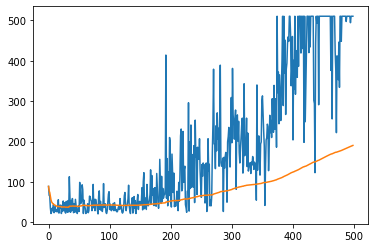

In [106]:
import gym

env = gym.make("CartPole-v1")
obs_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
MAX_EPISODE = 1000
MAX_STEPS = 500

lr = 1e-3
gamma = 0.995
import matplotlib.pyplot as plt
import numpy as np

agent = Agent1(env, gamma, lr)
scores = []
mean_scores = []
def run():
    for episode in range(MAX_EPISODE):
        state = env.reset()
        data1 = [] # [[s, a, r, s', done], [], ...]
        episode_reward = 0
        for steps in range(MAX_STEPS):
            action = agent.get_action(state)
            next_state, reward, done, _ = env.step(action)
            data1.append([state, action, reward, next_state, done])
            if not done:
                episode_reward += reward

            if done:
                episode_reward += reward + 10
                break
                
            state = next_state
        scores.append(episode_reward)
        mean_scores.append(np.mean(scores))
        if episode % 10 == 0:
            print("Episode " + str(episode) + ": Average" + str(np.mean(scores)))
        if np.mean(scores) >= 190: 
            print("Solved Reliably, Breaking now", episode)
            break
        agent.update1(data1)
    plt.plot(scores)
    plt.plot(mean_scores)
run()